# Playing Atari with Deep Reinforment Learning

The goal of the agent is to interact with the game by selecting actions s.t. maximises the (discounted) future rewards.

    E[R_0]= r_{0}+ γ*r_{1}+ γˆ2*r_{2} …… = E[∑t=0->n γ^t * r_{t+1}]

Defining the optimal policy as among all available actions at the current state, then choose the action that maximizes the expectated total R:

    Q*(s,a) = max(π) E[R_t |s_t=s, a_t=a, π]

if we assign the computation of successor states' reward R to some orcle V(s), now the expected value under optimal strategy following an important identity known as Bellman equation becomes:

    chooses a s.t. a = argmax(a') [E(r_t + γ*V(s_{t+1}))]

The basic idea behind reinformance learning algo is to estimate the action value function by using the Bellman equation above as iterative upate to Q_{i+1}(s,a). And such value iteration will eventually converge to the optimal action value function

Neural networks are universal function approximators, we can simply create one and train it to resemble Q.Combined with the Bellman equaition introduced above, this will give us the expected state action value to be the immediate reward plus the discounted accumulated value of the sucessor states as:

      Qπ (s,a) = r+ γ*Qπ (s′,π(s′))
    
      Q*(s,a) = E [r_t + γ*max(a')Q(s', a')|s, a]

In [15]:
import gym
from gym import envs
from gym import wrappers

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import argparse
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from network.DQN import DQN
from network.deepnet import Net




# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [16]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
DoubleTensor = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor
Tensor = FloatTensor


config = {
            "frame_size_h": 9,
            "frame_size_w": 9,
            "frame_size_d": 3,
            "action_list_n": 4,#83,
            "EPS_START": 0.4, #0.8, #1
            "EPS_END": 0.01, #0.1
            "EPS_DECAY": 200, #200,
            "BATCH_SIZE": 32,
            "GAMMA": 0.999,     
            "learning_rate": 0.00025,
            "reward_scale": 10,
            "replay_memory_capacity": 5000, #10000,
            "n_itr" : 150,
            "game_name": ""
            
        }

config_net = {
            "inputs_dim": 8,
            "hidden_dim": 100,
            "outputs_dim": 4 #83
}


# named tuple representing a single transition in enviornment
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))
epoch_durations = []
average_total_Q = []
average_total_reward = []
average_loss = []
eps_decay = []

In [22]:
def plot_durations():
    fig = plt.figure(figsize=(14,14))
    plt.clf()
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)

    reward_t = average_total_reward
    q_t = average_total_Q
    loss_ = average_loss
    eps_ = eps_decay
    
    #ax1.plot([x*y for x, y in zip(reward_t, epoch_durations)])
    ax1.plot(reward_t)
    ax2.plot(q_t)
    ax3.plot(loss_)
    ax4.plot(epoch_durations)
    # Take 100 episode averages and plot them too
    #if len(durations_t) >= 100:
    #    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #    means = torch.cat((torch.zeros(99), means))
     #   plt.plot(means.numpy())
        
    ax1.set_title('REWARD - Training '+ config["game_name"])
    ax2.set_title('Q VALUE - Training '+ config["game_name"])
    ax3.set_title('LOSS - Training ' + config["game_name"])
    ax4.set_title('Epoch Duration - Training ' + config["game_name"])
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax3.set_xlabel('Epoch')
    ax1.set_ylabel('Average Reward per Epoch')
    ax2.set_ylabel('Average Action value(Q) oer Episode')
    ax3.set_ylabel('Average Loss per Episode')
    ax4.set_ylabel('Number of Steps before crash')

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
     #   display.display(plt.gcf())
        
    print "\nAverage Reward Obtained: " + str(sum(reward_t)/config["n_itr"])
    print "Average Steps Per Epoch: " + str(sum(epoch_durations)/config["n_itr"])


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory =[]
        self.position = 0

    def save(self, *args):      # save a trasition
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position]=Transition(*args)
        self.position= (self.position+1) % self.capacity


    def sample(self, batch_size):       # select random batch of transitions from memory
        return random.sample(self.memory, batch_size)


    def __len__(self):
        return len(self.memory)

    
def piecewise_scheduler(optimizer, epoch):
    if epoch % 50 ==0 :
        for param_group in optimizer.param_groups:
            lr =  param_group['lr'] / 2
            param_group['lr']  = lr

    return optimizer

In [18]:
def obFixer(observation_space,observation): 
    """
    Fixes observation ranges scale to [-1, 1], uses hyperbolic tangent for infinite values
        Args: 
            obsercation_space[nparray]
            observation
        Return:
            newObservation[nparray]
    """
    newObservation = []
    
    if observation_space.__class__ == gym.spaces.box.Box:
        for space in range(observation_space.shape[0]):
            high = observation_space.high[space]
            low = observation_space.low[space]
            if high == np.finfo(np.float32).max or high == float('Inf'):    #tanh to scale for inf
                newObservation.append(math.tanh(observation[space]))
                
            else:                         # current value percentage% to the range high-low
                dif = high - low 
                percent = (observation[space]+abs(low))/dif
                newObservation.append(((percent * 2)-1).tolist())
    
    return np.asarray(newObservation)

In [19]:
class QLearningAgent(object):
    """
    Agent implementing Deep Q-learning with experience replay
    """

    def __init__(self, observation_space, action_space, learnable=None, lr_scheduler= None, replay_memory_capacity=None):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learnable = learnable
        self.epoch_done = 0

        #// initialize replay memory D to capacity N
        self.replay_memory = ReplayMemory(replay_memory_capacity if replay_memory_capacity is not None else config["replay_memory_capacity"])

        #// initialize Q network

        if self.learnable is not None:
            self.q = DQN(config["frame_size_h"], config["frame_size_w"], \
                         config["action_list_n"]) if self.learnable=='DQN' \
                    else \
                    Net(config_net["inputs_dim"], \
                        config["action_list_n"], config_net["hidden_dim"])
            
            self.q.float()    
            self.q.train(True)    
            self.loss =  torch.nn.MSELoss()  
            self.optimizer = optim.Adam(self.q.parameters(), lr=config["learning_rate"], betas=(0.001, 0.9), weight_decay=0.0001)
            if lr_scheduler:
                    self.optimizer = lr_scheduler(self.optimizer, self.epoch_done + 1)
            self.tanh_clip = nn.Tanh()
            
            
        else:
            self.q = None
            
        
        
    def act_random(self):
        action = self.action_space.sample()
        return action, 0    


      
    def act_learn(self, observation, eps=None):
        """
        Epsilon greedy control off-policy strategy      
            Args: 
                observation[DoubleTensor]: 
            Return: 
                action[int64] : action picked
                value[float]: estimated Q value of corresponding action picked
        """
        
        if eps is None:
            eps= config["EPS_END"] + (config["EPS_START"]-config["EPS_END"]) * \
                math.exp(-1. *  self.epoch_done / config["EPS_DECAY"])
            eps_decay.append(eps)

        # Compute Q-values for each action,
        # pick the action that maximizes Q or random action 
        observation = observation.view(config_net["inputs_dim"]) if self.learnable=='DQN' \
                     else observation.view(1, config_net["inputs_dim"])
        qvalue_list = self.q(Variable(observation, volatile=True).type(FloatTensor)) 
        
        #qvalue_list = self.tanh_clip(qvalue_list).data   # 11/9
        
        if np.random.random() > eps:
            qvalue, action = torch.max(qvalue_list.data, 1)
            action = action.numpy()[0][0]   #from tensor 
            print "========= Q ACTION PICKING "
            print "Q(s) to pick from: "+str(qvalue_list)
            print "Agent pick the best one: " + str(action)
            print "of Q-value: "+ str(qvalue)
            print "========= \n"
        else: 
            qvalue, _= torch.max(qvalue_list.data, 1)
            action, _= self.act_random()
        
        qvalue = qvalue.numpy()[0][0]
        return action, qvalue     # always return MAX Q possible in current prediction 11/9

    def train(self, env):
        self.epoch_done=0
        t_num=0
        #reward_total=0.    # for 9x9 go
        for i in range(config["n_itr"]):
            print('')
            print(' =============================> Epoch ' + str(self.epoch_done))

            obs = env.reset()
            obs = obFixer(self.observation_space, obs)
            qvalue_total=0.
            loss_total=0.
            loss_data_=0.
            reward_total=0.     # for lunar land
            

            for t in count():
                print(' episode: ' + str(t+1))
                
                # Select and perform the action
                action, qvalue = self.act_random() if self.q is None \
                                    else self.act_learn(torch.from_numpy(obs))
                obs2, reward, done, info = env.step(action)
                obs2 = obFixer(self.observation_space, obs2)
                
                # Store transition into memory
                if done: 
                    obs2 = None

                    
                #_reward_ = config["reward_scale"]*reward #10. #5.+reward 
                _reward_ =0.
                if reward>0:
                    _reward_ = 1
                elif reward<0:
                    _reward_ = -1

                
                ## I'm guaranteeing half of good transitions  
                if (t_num%2==0 and reward >0) or (t_num%2!=0 and reward<0):
                    self.replay_memory.save(obs, action, _reward_, obs2)
                    t_num += 1
                          
                
                # Perform on step of optimization to Q net
                if self.q is not None:  
                    loss_data_ = self.optimize_model()

                    
                reward_total += reward
                qvalue_total += qvalue
                loss_total += loss_data_
                obs = obs2 
                
                env.render()

                if done:
                    print 'Good Land!' if reward > 0 else 'Crash!'
                    average_total_reward.append(reward_total/(t+1))
                    average_total_Q.append(qvalue_total/(t+1))
                    average_loss.append(loss_total/(t+1))
                    epoch_durations.append(t+1)
                    plot_durations()
                    break


            self.epoch_done += 1

        print('Complete')
        env.render(close=True)
        env.close()
        #plt.ioff()
        #plt.show()


    def optimize_model(self):

        BATCH_SIZE = config["BATCH_SIZE"]
        ACTION_LIST = config["action_list_n"]
        INPUT_SIZE = config_net["inputs_dim"]
        if len(self.replay_memory) < BATCH_SIZE:
            return 0.0

        transitions = self.replay_memory.sample(BATCH_SIZE)

        batch = Transition(*zip(*transitions))
        print ('sample batch from memory...\n')
        
              
        # Concatenate the batch elements of each
        # state, action , reward in every transition
        state_batch = Variable(torch.from_numpy(np.asarray(batch.state))).float()    ##.double()
        action_batch = Variable(torch.from_numpy(np.asarray(batch.action))).float() ##.double()
        reward_batch = Variable(torch.from_numpy(np.asarray(batch.reward))).float()  ##.double()

        self.optimizer.zero_grad()
        
        # Compute Q(s_t, a) by model
        # the model computes Q(s_t) and we select the columns
        # of actions taken in record
        state_values_ = self.q(\
                    state_batch if self.learnable=='DQN' else state_batch.view(-1,INPUT_SIZE)\
                    )
        ##############
        #print (" V(s_{t}, a): "+ str(state_values_))
        ##############
        ##############
        #print ("action batch: "+ str(action_batch))
        ##############
        

        state_action_values = state_values_[0].view(1,ACTION_LIST).index_select(1, action_batch[0].long())
        for i in range(len(action_batch)-1):
            state_action_values = torch.cat((state_action_values, \
                                    state_values_[i+1].view(1,ACTION_LIST).index_select(1, action_batch[i+1].long())),0)
        state_action_values = state_action_values.index_select(1, Variable(torch.LongTensor([0])))
        
        #state_action_values = self.tanh_clip(state_action_values)  #11/9
        
        ##############
        print (" Q(s_{t}, a): "+ str(state_action_values))
        ##############

        
        non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,\
                                             batch.next_state)))
        # We don't want backprop expected action values, volatile shuts down requires-grad
        non_final_next_states = Variable (torch.cat([torch.from_numpy(x) for x in np.asarray(batch.state) \
                                           if x is not None]), volatile=True).float()        ##.double()
           
        # Compute state value V(s_{t+1}) by model for all next states,
        # then select the maxQ value of each:
        ## MAX(a)Q(s_{t+1}, a)
        next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor)).float()       ##.double()
        next_state_values[non_final_mask], _ = torch.max( self.q( \
            non_final_next_states if self.learnable=='DQN' \
                    else non_final_next_states.view(-1,INPUT_SIZE) \
            ), 1)   
        
        #next_state_values = self.tanh_clip(next_state_values)   #11/9
        
        #############
        print("V(s_{t+1}): " + str(next_state_values))
        ############

        # Compute the expected Q values
        #
        ## Bellman equation
        ## Q_{t+1}(s,a) = r + gamma * MAX(a')Q(s', a')
        expected_state_action_values =  reward_batch + (next_state_values * config["GAMMA"]) 
        
        #############
        print("r: "+str(reward_batch))
        print("y_{t}: " + str(expected_state_action_values))
        ############
        

        # Compute Mean-Square Error loss from Q and expected Q*
        #
        ## loss(x, y) = 1/n sum|x-y|^2
        loss = self.loss(state_action_values, expected_state_action_values)
        #loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        ##############
        #print("LOSS: " + str( loss.data.numpy()[0]))
        ################
        
        # Optimize model
        
        loss.backward()
        self.optimizer.step()
        
        return loss.data.numpy()[0]
    
    

The algorithm follows off-policy but epsilon controlled greedy strategy, where there is a probaility of epsilon value that action selected by the model (with the estimated max Q value) and select random action with proablity (1-epsilon).

During training, after each episode of interaction with the game enviornment (collect reward, and the next state by taking some action), we will push a transition T = { s{t}, reward, action, s{t+1} } to the replay memory D and we sample a batch of transitions from memory when we optimize our network and compute the following:

- the state action value estimated by model Q (s_t, a_t),
- the expected action state value y_i (also the target/label) estimated by model max(a')[Q(s',a')|s,a], with Bellman equation this giving us:

      y_i = Es'->end[ r + gamma * max(a')Q(s',a')|s, a ]

note that in terminal state where V(s)=0, here Q(s_{t-1}, a) = rt

Loss is applied on the differece of predicted and expected by mean square error loss function in the preliminary experiments.


## Results On LunarLander-v2

In [20]:
config['game_name'] = 'LunarLander-v2'

Reward for moving from the top of the screen to landing pad at coordinate [0,0] and zero speed is about 100..140 points. Four actions:
Do nothing,
Fire left orientation engine,
Fire main engine,
Fire right orientation engine,

Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

### FOUNDING & NOTE

- tanh > relu, w/ BN
- store 50% good T to memory, with r>0.  give learning
- scale r by k=10, with memory D narrow down to half 5,000. give more learning
- 

#### RANDOM AGENT PLAY


Average Reward Obtained: -2.563304071
Average Steps Per Epoch: 88


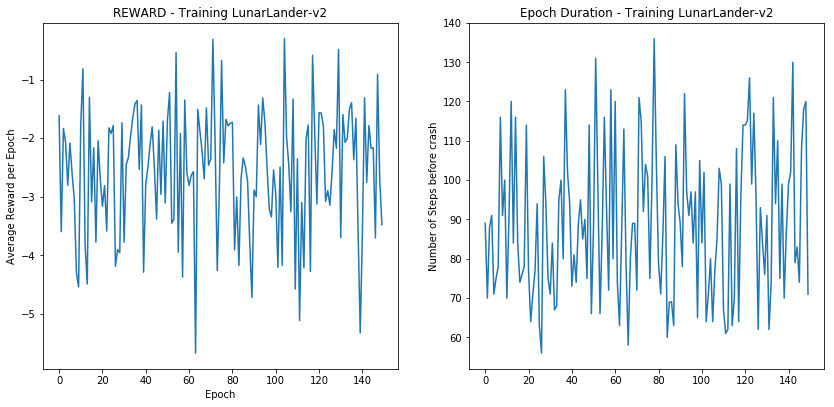

In [19]:
#env = gym.make(config['game_name'])
#random_agent = QLearningAgent(env.observation_space, env.action_space)
#random_agent.train(env)
plot_durations()

#### Q-LEARNING AGENT PLAY


 remove r clap 
 remove last relu before output, get normal est.Q value 
 tanh replace relu. 
 store 50% good transition

 narrow down D 10,000 tp 5,000, with r scale factor = 10 

lr=0.0008


{'EPS_END': 0.01, 'learning_rate': 8e-05, 'action_list_n': 4, 'n_itr': 150, 'GAMMA': 0.999, 'reward_scale': 10, 'frame_size_w': 9, 'EPS_DECAY': 200, 'BATCH_SIZE': 32, 'frame_size_d': 3, 'game_name': 'LunarLander-v2', 'replay_memory_capacity': 5000, 'frame_size_h': 9, 'EPS_START': 0.4}

Average Reward Obtained: -3.60390963152
Average Steps Per Epoch: 167


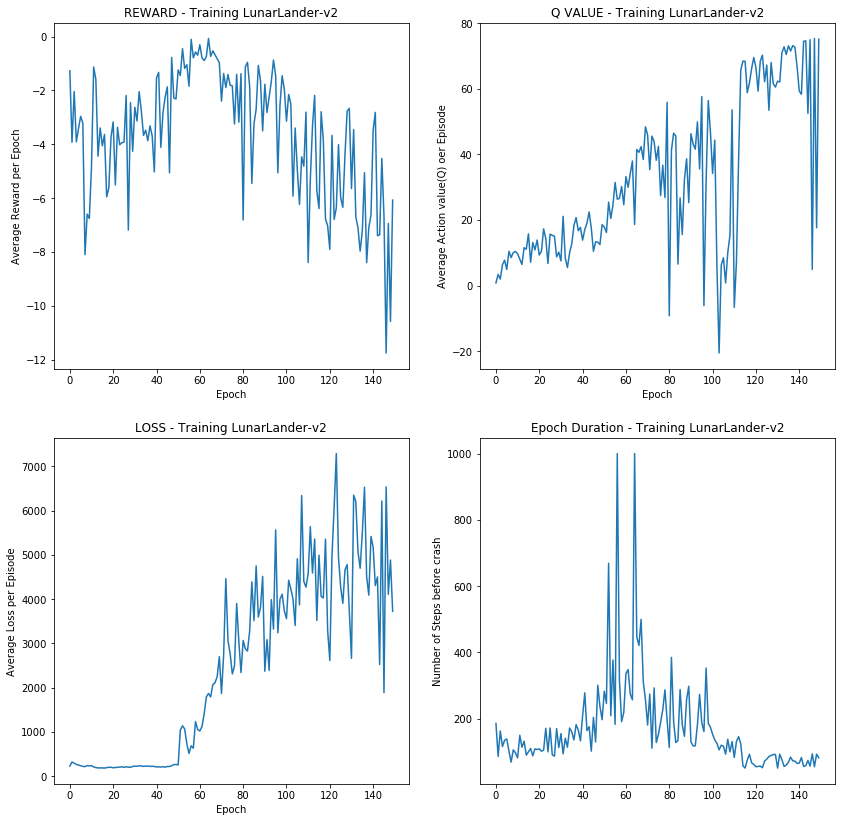

In [44]:
config["learning_rate"]=0.00008
print "\n remove r clap \n remove last relu before output, get normal est.Q value \n tanh replace relu. \n store 50% good transition"
print "\n narrow down D 10,000 tp 5,000, with r scale factor = 10 \n"
print "lr=0.0008\n\n"
print config
#env_ = gym.make(config['game_name'])
#random_agent = QLearningAgent(env_.observation_space, env_.action_space, learnable="deepNet")
#random_agent.train(env_)
plot_durations()

{'EPS_END': 0.01, 'learning_rate': 0.00015, 'action_list_n': 4, 'n_itr': 150, 'GAMMA': 0.999, 'reward_scale': 10, 'frame_size_w': 9, 'EPS_DECAY': 200, 'BATCH_SIZE': 32, 'frame_size_d': 3, 'game_name': 'LunarLander-v2', 'replay_memory_capacity': 5000, 'frame_size_h': 9, 'EPS_START': 0.4}




Average Reward Obtained: -4.46996564396
Average Steps Per Epoch: 90


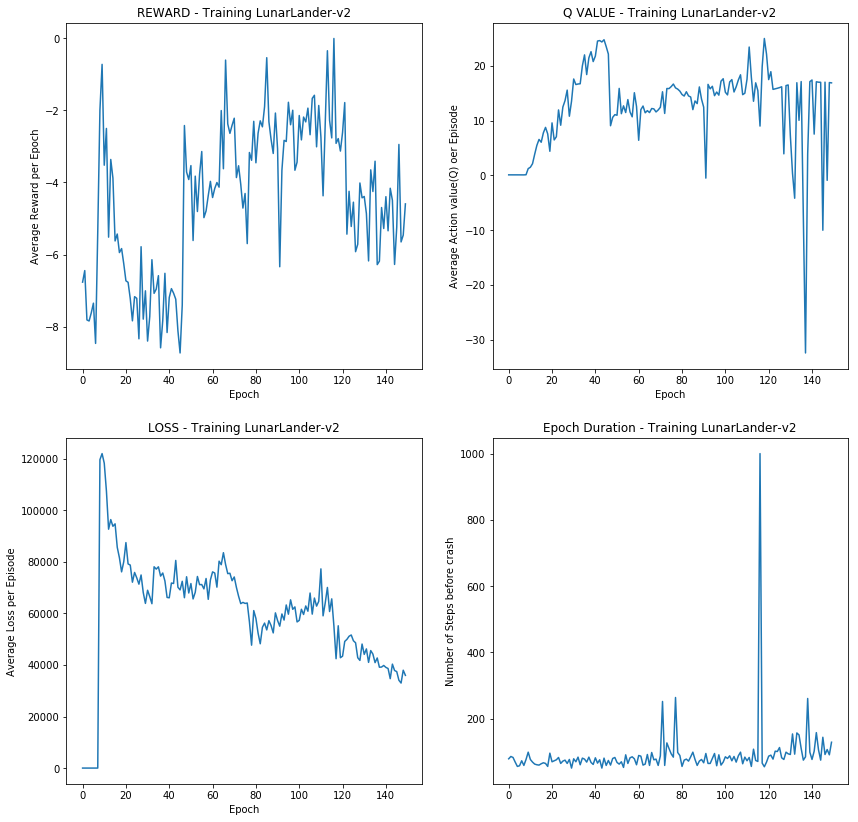

In [59]:
#config["learning_rate"]=0.00015
#env_ = gym.make(config['game_name'])
#random_agent = QLearningAgent(env_.observation_space, env_.action_space, learnable="deepNet", lr_scheduler=piecewise_scheduler)
#random_agent.train(env_)
print config
print "\n\n"
plot_durations()

r => -1,0, 1

{'EPS_END': 0.01, 'learning_rate': 0.0005, 'action_list_n': 4, 'n_itr': 150, 'GAMMA': 0.999, 'reward_scale': 10, 'frame_size_w': 9, 'EPS_DECAY': 200, 'BATCH_SIZE': 32, 'frame_size_d': 3, 'game_name': 'LunarLander-v2', 'replay_memory_capacity': 5000, 'frame_size_h': 9, 'EPS_START': 0.4}



Average Reward Obtained: -3.18039162634
Average Steps Per Epoch: 141


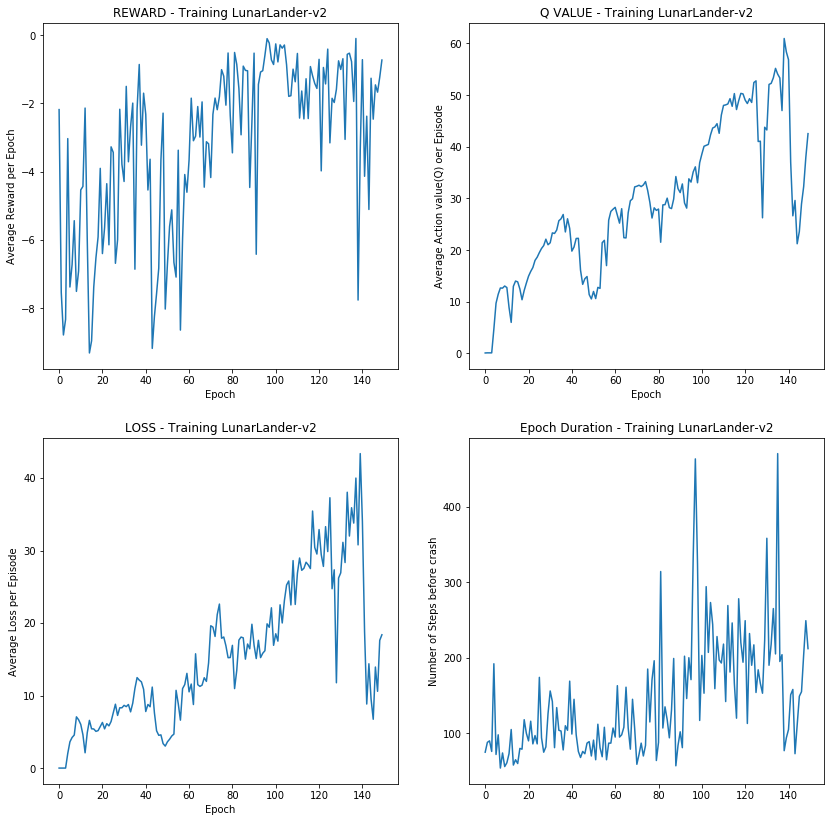

In [39]:
config["learning_rate"]=0.0005
print "r => -1,0, 1\n"
print config
print "\n"
#env_ = gym.make(config['game_name'])
#random_agent = QLearningAgent(env_.observation_space, env_.action_space, learnable="deepNet")
#random_agent.train(env_)
plot_durations()

d=epoch_durations 
q=average_total_Q 
r=average_total_reward 
l=average_loss 
ep=eps_decay

r => -1,0, 1

{'EPS_END': 0.01, 'learning_rate': 0.0005, 'action_list_n': 4, 'n_itr': 150, 'GAMMA': 0.999, 'reward_scale': 10, 'frame_size_w': 9, 'EPS_DECAY': 200, 'BATCH_SIZE': 32, 'frame_size_d': 3, 'game_name': 'LunarLander-v2', 'replay_memory_capacity': 10000, 'frame_size_h': 9, 'EPS_START': 0.4}



Average Reward Obtained: -2.62085377663
Average Steps Per Epoch: 155


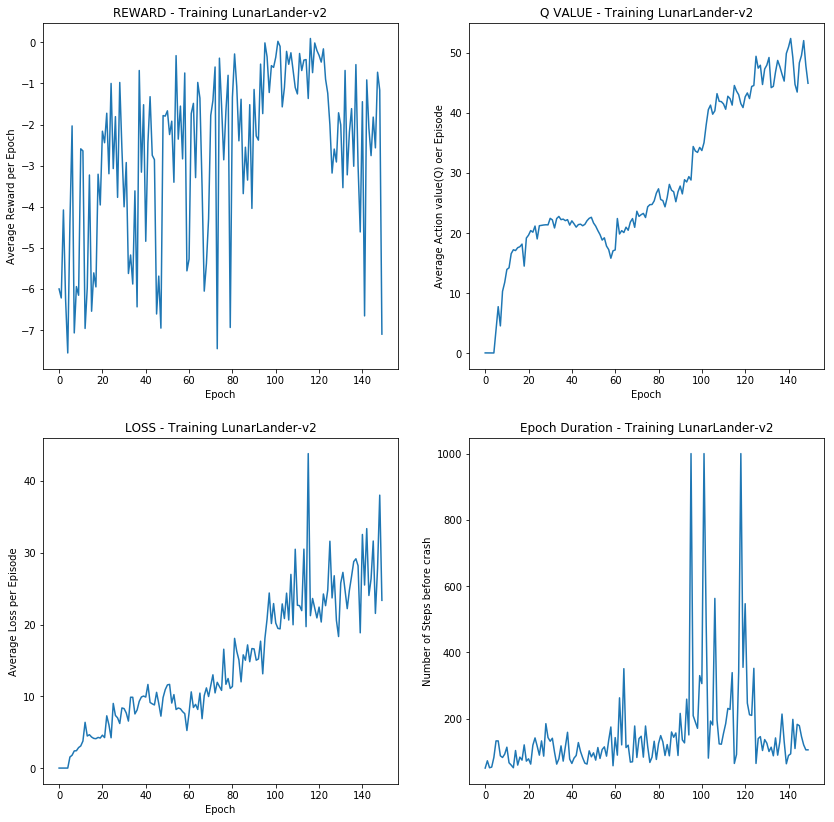

In [24]:
config["learning_rate"]=0.0005
config["replay_memory_capacity"]=10000
print "r => -1,0, 1\n"
print config
print "\n"
#env_ = gym.make(config['game_name'])
#random_agent = QLearningAgent(env_.observation_space, env_.action_space, learnable="deepNet")
#random_agent.train(env_)
plot_durations()
d1=epoch_durations 
q1=average_total_Q 
r1=average_total_reward 
l1=average_loss 
ep1=eps_decay

In [ ]:
print r